In [438]:
# FETCH THE CSV DATA FROM THE API

from requests import get
import pandas as pd

base_url = "https://clinicaltrials.gov/api/query/study_fields?" # base url for our endpoint

expr = "multiple myeloma" # basic search term
actual_expr = expr.replace(' ', '+') # replace spaces in expr with '+'

fields = ["BriefTitle", "PrimaryOutcomeMeasure", "PrimaryOutcomeTimeFrame", "SecondaryOutcomeMeasure", "OverallStatus", "Phase"] # fields we want to get
actual_fields = ",".join(fields) # join fields with commas

fmt = "csv" # get in csv format

num_results = 999 # number of results we want – 1000 is maximum

params = {
    "expr": actual_expr,
    "fields": actual_fields,
    "min_rnk": "1",
    "max_rnk": str(num_results),
    "fmt": fmt
}

response = get(base_url, params=params)

if response.ok:
    print("Request successful!")
else:
    print("Request failed!")
print("\n\n" + response.text)

Request successful!


"APIVrs: 1.01.05"
"DataVrs: 2023:05:12 00:01:11.028"
"Expression: multiple+myeloma"
"NStudiesAvail: 452005"
"NStudiesFound: 2702"
"MinRank: 1"
"MaxRank: 999"
"NStudiesReturned: 999"
"Field Names: BriefTitle,PrimaryOutcomeMeasure,PrimaryOutcomeTimeFrame,SecondaryOutcomeMeasure,OverallStatus,Phase"

"Rank","BriefTitle","PrimaryOutcomeMeasure","PrimaryOutcomeTimeFrame","SecondaryOutcomeMeasure","OverallStatus","Phase"
1,"Early Detection of Multiple Myeloma to Fight Cancer Disparities: A Screening and Patient Navigation Program","To conduct and evaluate a study that incorporates patient navigation programs to recruit and screen participants for Multiple Myeloma and its disease precursors, MGUS or smoldering MM|To conduct and evaluate a study that incorporates patient navigation programs to recruit and screen participants for Multiple Myeloma and its disease precursors, MGUS or smoldering MM|To study participant knowledge of Multiple Myeloma","12 months|12 months|12 mo

In [439]:
# WRITE THE CSV DATA TO A FILE

import csv
lines = response.text.split('\n') # split by newlines

with open('output.csv', mode='w', newline='') as file: # open a file to write to
    writer = csv.writer(file, delimiter=';') # create a csv writer
    headers = ['Rank'] + fields # create headers
    writer.writerow(headers) # write headers

    for line in lines[11:]: # skip first 11 lines
        row = [txt for txt in line.split(',\"') if txt != ""] # split by commas followed by a quote, remove anything empty
        
        split_count = 0
        for i,text in enumerate(row):
            if split_count == 0 and row[i].count('|') >= 1: # if there are vertical bars
                split_count = row[i].count('|')+1 # count the number of copies of other fields we will need to make
            row[i] = text.replace('\"', '') # remove quotes
             
        if split_count: # we need to split by the primary outcome measures
            for i,text in enumerate(row):
                if row[i].count('|') >= 1:
                    row[i] = row[i].split('|') # split by vertical bars
                else:
                    row[i] = [row[i]]*split_count # make it a list
            # fetch each new row and write to file
            for r in zip(*row):
                writer.writerow(r)
        else:
            writer.writerow(row) # write row as it is
    print("File written successfully!")

File written successfully!


In [440]:
# READ INTO A PANDAS DATAFRAME
df = pd.read_csv("output.csv", delimiter=';')
numtrials = df["BriefTitle"].unique().shape[0]
df

,Rank,BriefTitle,PrimaryOutcomeMeasure,PrimaryOutcomeTimeFrame,SecondaryOutcomeMeasure,OverallStatus,Phase
0,1,Early Detection of Multiple Myeloma to Fight C...,To conduct and evaluate a study that incorpora...,12 months,Not yet recruiting,Not Applicable,NaN
1,1,Early Detection of Multiple Myeloma to Fight C...,To conduct and evaluate a study that incorpora...,12 months,Not yet recruiting,Not Applicable,NaN
2,1,Early Detection of Multiple Myeloma to Fight C...,To study participant knowledge of Multiple Mye...,"12 months,",Not yet recruiting,Not Applicable,NaN
3,2,Multiple Myeloma (MM) Profile in Brazil: A Ret...,Number of Multiple Myeloma (MM) Participants C...,From initial diagnosis up to end of follow up ...,Overall Survival (OS),"Completed,",NaN
4,2,Multiple Myeloma (MM) Profile in Brazil: A Ret...,Number of Multiple Myeloma (MM) Participants C...,From initial diagnosis up to end of follow up ...,Duration of Treatment,"Completed,",NaN
...,...,...,...,...,...,...,...
3711,998,Carfilzomib in Treating Patients With Multiple...,Overall Response Rate (ORR) After 8 Courses of...,At 32 weeks,Progression-free Survival (PFS),Terminated,Phase 2
3712,998,Carfilzomib in Treating Patients With Multiple...,Overall Response Rate (ORR) After 8 Courses of...,At 32 weeks,Time to Progression (TTP),Terminated,Phase 2
3713,998,Carfilzomib in Treating Patients With Multiple...,Overall Response Rate (ORR) After 8 Courses of...,At 32 weeks,Duration of Response (DOR),Terminated,Phase 2
3714,998,Carfilzomib in Treating Patients With Multiple...,Overall Response Rate (ORR) After 8 Courses of...,At 32 weeks,Treatment Related Adverse Events Grade 3 or Hi...,Terminated,Phase 2


In [441]:
df.PrimaryOutcomeTimeFrame.value_counts()
# THIS IS GOING TO BE VERY TOUGH TO DEAL WITH...

2 years                                   106
6 months                                   70
1 year                                     66
3 years                                    51
28 days                                    42
                                         ... 
Baseline through 4 weeks of treatment,      1
100 Days post transplant                    1
6 months post transplant                    1
14 days                                     1
100 weeks                                   1
Name: PrimaryOutcomeTimeFrame, Length: 966, dtype: int64

In [442]:
df.OverallStatus.value_counts()
# We probably should remove everything that is "Unknown Status" or random dates or other nonsense

Completed                   1131
Recruiting                   610
Active, not recruiting       487
Terminated                   339
Unknown status               152
Phase 2                      141
Completed,                   122
Withdrawn                    110
Not yet recruiting           109
Recruiting,                   96
Phase 3                       67
Active, not recruiting,       50
Phase 1                       47
Not Applicable                22
Terminated,                   22
Unknown status,               21
Not yet recruiting,           10
Phase 4                        9
Suspended                      7
Enrolling by invitation        4
Early Phase 1                  4
Enrolling by invitation,       2
Name: OverallStatus, dtype: int64

In [443]:
# Clean up by the overallstatus column
df = df[df['OverallStatus'].isin(['Completed', 'Terminated', 'Withdrawn', 'Active not recruiting', 'Recruiting', 'Enrolling by invitation', 'Suspended', 'Not yet recruiting'])]
df.OverallStatus.value_counts()
# So much better

Completed                  1131
Recruiting                  610
Terminated                  339
Withdrawn                   110
Not yet recruiting          109
Suspended                     7
Enrolling by invitation       4
Name: OverallStatus, dtype: int64

In [444]:
# # CONVERT THE LastUpdatePostDate COLUMN TO A DATETIME
# df['LastUpdatePostDate'] = pd.to_datetime(df['LastUpdatePostDate'])
# df

,Rank,BriefTitle,PrimaryOutcomeMeasure,PrimaryOutcomeTimeFrame,SecondaryOutcomeMeasure,OverallStatus,Phase
5,3,CAR-T Cells Therapy in Relapsed/Refractory Mul...,Adverse events that Are related to treatment,2 years,Estimate 2 year overall survival(OS) after inf...,Terminated,Not Applicable
23,7,Impact of Paramedical Consultations in Oncolog...,Comparison of quality of life evolution in out...,6 months,Qualitative evaluation of quality of life,Recruiting,Not Applicable
29,9,Comparison of F-18 FDG and C-11 Acetate PET in...,Mean Multiple Myeloma Lesions Detected,"Day 1, Day 2",Visual Image Analysis of Detected Multiple Mye...,Completed,Phase 2
31,11,A Study of Siltuximab (Anti- IL 6 Monoclonal A...,One-Year Progression-Free Survival (PFS) Rate,Up to 1 Year,Progressive Disease Indicator Rate (PDIR) at 6...,Completed,Phase 2
40,13,"Phase II Study of Thalidomide, Clarithromycin,...",Effect of Drug Combination on Multiple Myeloma,This was collected from patients for their dur...,Median Time to Maximum Response,Completed,Phase 2
...,...,...,...,...,...,...,...
3685,993,"A Study of JNJ-68284528, a Chimeric Antigen Re...",Percentage of Participants with Negative Minim...,At least 1 year after JNJ-68284528 infusion on...,Overall Response Rate (ORR),Recruiting,Phase 2
3704,995,A Randomized Study With Oral Melphalan + Predn...,To assess the efficacy,from 8 to 12 months,To evaluate the Overall Survival (OS) in the 2...,Completed,Phase 2
3706,996,Pembrolizumab Cyclophosphamide and Lenalidomid...,Dose Limiting Toxicities (DLT) in dose finding...,"End of cycle 1 of treatment, 4 weeks",Safety of trial treatment,Withdrawn,Phase 1
3708,997,"Lenalidomide, Thalidomide and Dexamethasone in...",Number of Participants With Dose Limitations T...,After one 28-day cycle,Time to Progression,Completed,Phase 1


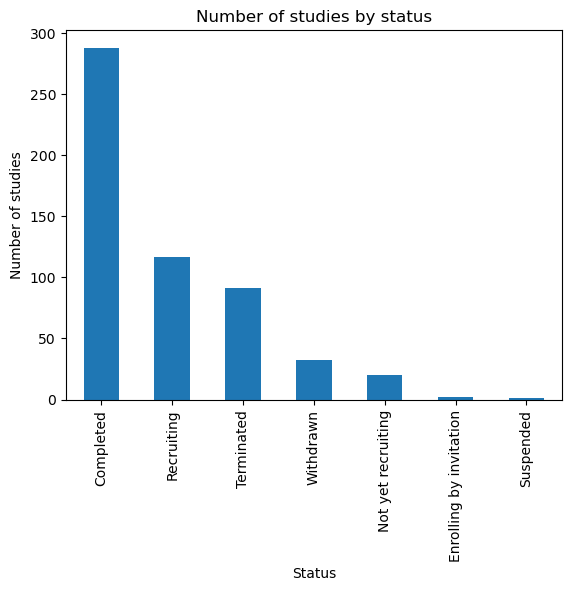

In [445]:
# Sample plot
per_study = df.drop_duplicates(subset='BriefTitle', keep='first') # remove duplicates from BriefTitle column to get a count of unique studies
per_study.OverallStatus.value_counts().plot(kind='bar', title='Number of studies by status', xlabel='Status', ylabel='Number of studies')
per_study

In [446]:
df["PrimaryOutcomeTimeFrame"].value_counts()[-600:-540]
# messing around with the timeframes

2 years                                                                                                                                                                                                                                               61
6 months                                                                                                                                                                                                                                              61
1 year                                                                                                                                                                                                                                                40
28 days                                                                                                                                                                                                                                               38
24 M

In [447]:
df["PrimaryOutcomeMeasure"].unique().size / df["Rank"].unique().size
# 1.33 primary outcome measures per trial

1.3339382940108893

In [448]:
# completed_studies = per_study[per_study["OverallStatus"] == "Completed"]
# completed_studies.sort_values(by="LastUpdatePostDate", ascending=False)
# # completed_studies[:1]["BriefTitle"].values[0]
# completed_studies[-1:]

In [449]:
# CLASSIFYING THE OUTCOME MEASURES

# Define the category lists
orr_keywords = set(['orr', 'objective response', 'overall response', 'response rate'])
cr_keywords = set(['complete response', 'cr', 'complete-response'])
pr_keywords = set(['partial response', 'pr', 'partial-response'])
ae_keywords = set(['AE', 'adverse events', 'side effects'])
it_keywords = set(['infusion time', 'administration time'])
mtd_keywords = set(['maximum tolerated dose', 'mtd', 'tolerance'])
s_keywords = set(['severity', 'grading'])
dlt_keywords = set(['dose limiting', 'dose-limiting', 'dlt', 'toxicity', 'dose limit', 'dose-limit'])
pfs_keywords = set(['progression-free', 'pfs', 'progression free'])
dur_keywords = set(['duration of response', 'dor'])
cmax_keywords = set(['cmax'])
tmax_keywords = set(['tmax'])
auc_keywords = set(['auc'])
pharmaco_keywords = set(['pharmacokinetics', 'pharmacodynamics'])
death_keywords = set(['death', 'dead', 'die', 'mortal'])
imwg_keywords = set(['imwg', 'international myeloma working group'])
mrd_keywords = set(['mrd', 'minimal residual', 'residual', 'minimal disease', 'minimum residual'])

# Function to classify outcome measures into categories
def classify_outcome_measure(outcome_measure):
    for keyword in orr_keywords:
        if keyword in outcome_measure.lower():
            return 'ORR'
    for keyword in ae_keywords:
        if keyword in outcome_measure.lower():
            return 'AE'
    for keyword in it_keywords:
        if keyword in outcome_measure.lower():
            return 'IT'
    for keyword in mtd_keywords:
        if keyword in outcome_measure.lower():
            return 'MTD'
    for keyword in s_keywords:
        if keyword in outcome_measure.lower():
            return 'Severity'
    for keyword in dlt_keywords:
        if keyword in outcome_measure.lower():
            return 'DLT'
    for keyword in pfs_keywords:
        if keyword in outcome_measure.lower():
            return 'PFS'
    for keyword in dur_keywords:
        if keyword in outcome_measure.lower():
            return 'DOR'
    for keyword in cr_keywords:
        if keyword in outcome_measure.lower():
            return 'CR'
    for keyword in pr_keywords:
        if keyword in outcome_measure.lower():
            return 'PR'
    for keyword in pharmaco_keywords:
        if keyword in outcome_measure.lower():
            return 'PHARM'
    # if "pharmaco" in outcome_measure.lower():
    #     for keyword in cmax_keywords:
    #         if keyword in outcome_measure.lower():
    #             return 'Cmax'
    #     for keyword in tmax_keywords:
    #         if keyword in outcome_measure.lower():
    #             return 'Tmax'
    #     for keyword in auc_keywords:
    #         if keyword in outcome_measure.lower():
    #             return 'AUC'
    for keyword in death_keywords:
        if keyword in outcome_measure.lower():
            return 'Mortality'
    for keyword in mrd_keywords:
        if keyword in outcome_measure.lower():
            return 'MRD'
    for keyword in imwg_keywords:
        if keyword in outcome_measure.lower():
            return 'IMWG'
    return 'Unclassified'

In [450]:
# Apply the function to the dataframe
df['PrimaryCat'] = df['PrimaryOutcomeMeasure'].apply(classify_outcome_measure)
df['SecondCat'] = df['SecondaryOutcomeMeasure'].apply(classify_outcome_measure)

/var/folders/f1/87whmjt97m90gfstrm2p61d80000gn/T/ipykernel_10192/4119259224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PrimaryCat'] = df['PrimaryOutcomeMeasure'].apply(classify_outcome_measure)
/var/folders/f1/87whmjt97m90gfstrm2p61d80000gn/T/ipykernel_10192/4119259224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SecondCat'] = df['SecondaryOutcomeMeasure'].apply(classify_outcome_measure)


<AxesSubplot:title={'center':'Number of studies by outcome measure category'}, xlabel='Category', ylabel='Number of studies'>

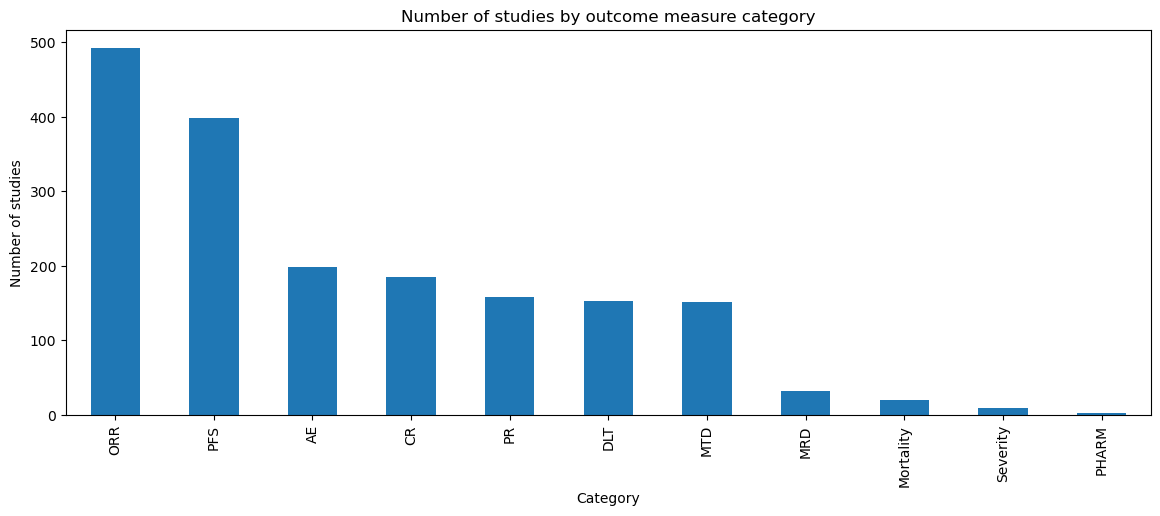

In [451]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
classifiedcounts = df[df['PrimaryCat'] != 'Unclassified']['PrimaryCat'].value_counts()
classifiedcounts.plot(kind='bar', title='Number of studies by outcome measure category', xlabel='Category', ylabel='Number of studies')
# NOT PER PHASE

In [452]:
# looking at all the unclassified ones
df[df["PrimaryCat"] == "Unclassified"]['PrimaryOutcomeMeasure'].unique()

array(['Comparison of quality of life evolution in outpatients with multiple myeloma between the two groups',
       'Mean Multiple Myeloma Lesions Detected',
       'Effect of Drug Combination on Multiple Myeloma',
       'Determine antitumor activity of ultrahigh dose dexamethasone (UHDD) as monotherapy in relapsed multiple myeloma.',
       'User average weekly log-in rates over the duration of follow-up from patients with MM and HCPs',
       'Recommended phase II dose (RPTD)', 'number of myeloma lesions',
       'Rate of Response in Participants Receiving Fenofibrate Therapy',
       'Number of Patients Who Develop Immunologic Response to Nivolumab and the DC/MM Fusion Vaccine',
       'Response of relapsed refractory multiple myeloma (RRMM) patient to elotuzumab, selinexor, and dexamethasone (ESd).',
       'Response', 'Number of whole-body bone lesions',
       'Number of bone lesions within defined skeletal areas',
       'Remission status of multiple myeloma',
       'Incidenc

In [453]:
# i think i never ended up using this and just used the cell below
def which_phase(phase):
    if "1" in phase:
        return "Phase 1"
    elif "2" in phase:
        return "Phase 2"
    elif "3" in phase:
        return "Phase 3"
    elif "4" in phase:
        return "Phase 4"
    else:
        return "Unknown"


def get_phase(rows):
    compressed_row = rows.iloc[0] 
    compressed_row["Phase"] = which_phase(rows["Phase"].values[0])
    return compressed_row


In [454]:
key = """ORR: Objective Response Rate
CR: Complete Response
PR: Partial Response
AE: Adverse Events
IT: Infusion Time
MTD: Maximum Tolerated Dose
DLT: Dose Limiting Toxicity
PFS: Progression Free Survival
DOR: Duration of Response
IMWG: International Myeloma Working Group
MRD: Minimal Residual Disease
PHARM: Pharmacokinetics
"""

def num_studies(series):
    filt = series.drop_duplicates(subset='BriefTitle', keep='first') # remove duplicates from BriefTitle column to get a count of unique studies
    return filt.shape[0]

# plot stuff!!!!!!!!!!!
def make_plots(endpoints, phase, show_key = True):
    """
    Make plots for trials in a certain phase and with certain endpoints

    Args:
        endpoints (bool): whether or not the endpoints are primary outcome measures
        phase (int): which phase to look at (1, 2, 3, 4)
    """
    if endpoints:
        endpoints = "PrimaryCat"
    else:
        endpoints = "SecondCat"
    phase = "Phase " + str(phase)
    
    intermediate = df[(df[endpoints] != 'Unclassified') & (df['Phase'] == phase)]
    totalcounts = intermediate[endpoints].value_counts()
    totalcounts /= totalcounts.sum()
    
    terminated = intermediate[intermediate["OverallStatus"] == "Terminated"]
    terminatedcounts = terminated[endpoints].value_counts()
    terminatedcounts /= terminatedcounts.sum()
    
    withdrawn = intermediate[intermediate["OverallStatus"] == "Withdrawn"]
    withdrawncounts = withdrawn[endpoints].value_counts()
    withdrawncounts /= withdrawncounts.sum()
    
    completed = intermediate[intermediate["OverallStatus"] == "Completed"]
    completedcounts = completed[endpoints].value_counts()
    completedcounts /= completedcounts.sum()
    
    fig, ax = plt.subplots(2, 2, figsize=(13, 10))
    endpoints = endpoints.replace("Cat", " Outcome Measures").replace("Second", "Secondary")
    fig.suptitle(f'{endpoints} for {phase} studies', fontsize=24, y = 1)

    
    totalcounts.plot(kind='bar', title=f'All {num_studies(intermediate)} Studies',  ylabel='Relative Frequency', ax=ax[0,0])
    terminatedcounts.plot(kind='bar', title=f'Terminated Studies (sample size: {num_studies(terminated)})', ylabel='Relative Frequency', ax=ax[0,1])
    withdrawncounts.plot(kind='bar', title=f'Withdrawn Studies (sample size: {num_studies(withdrawn)})', ylabel='Relative Frequency', ax=ax[1,0])
    completedcounts.plot(kind='bar', title=f'Completed Studies (sample size: {num_studies(completed)})', ylabel='Relative Frequency', ax=ax[1,1])
    
    if show_key:
        figtext_kwargs = {'x': 0.1, 'y': -0.25, 's': key, 'ha': 'left', 'va': 'bottom', 'fontsize': 14}
        fig.text(**figtext_kwargs)
    fig.tight_layout()

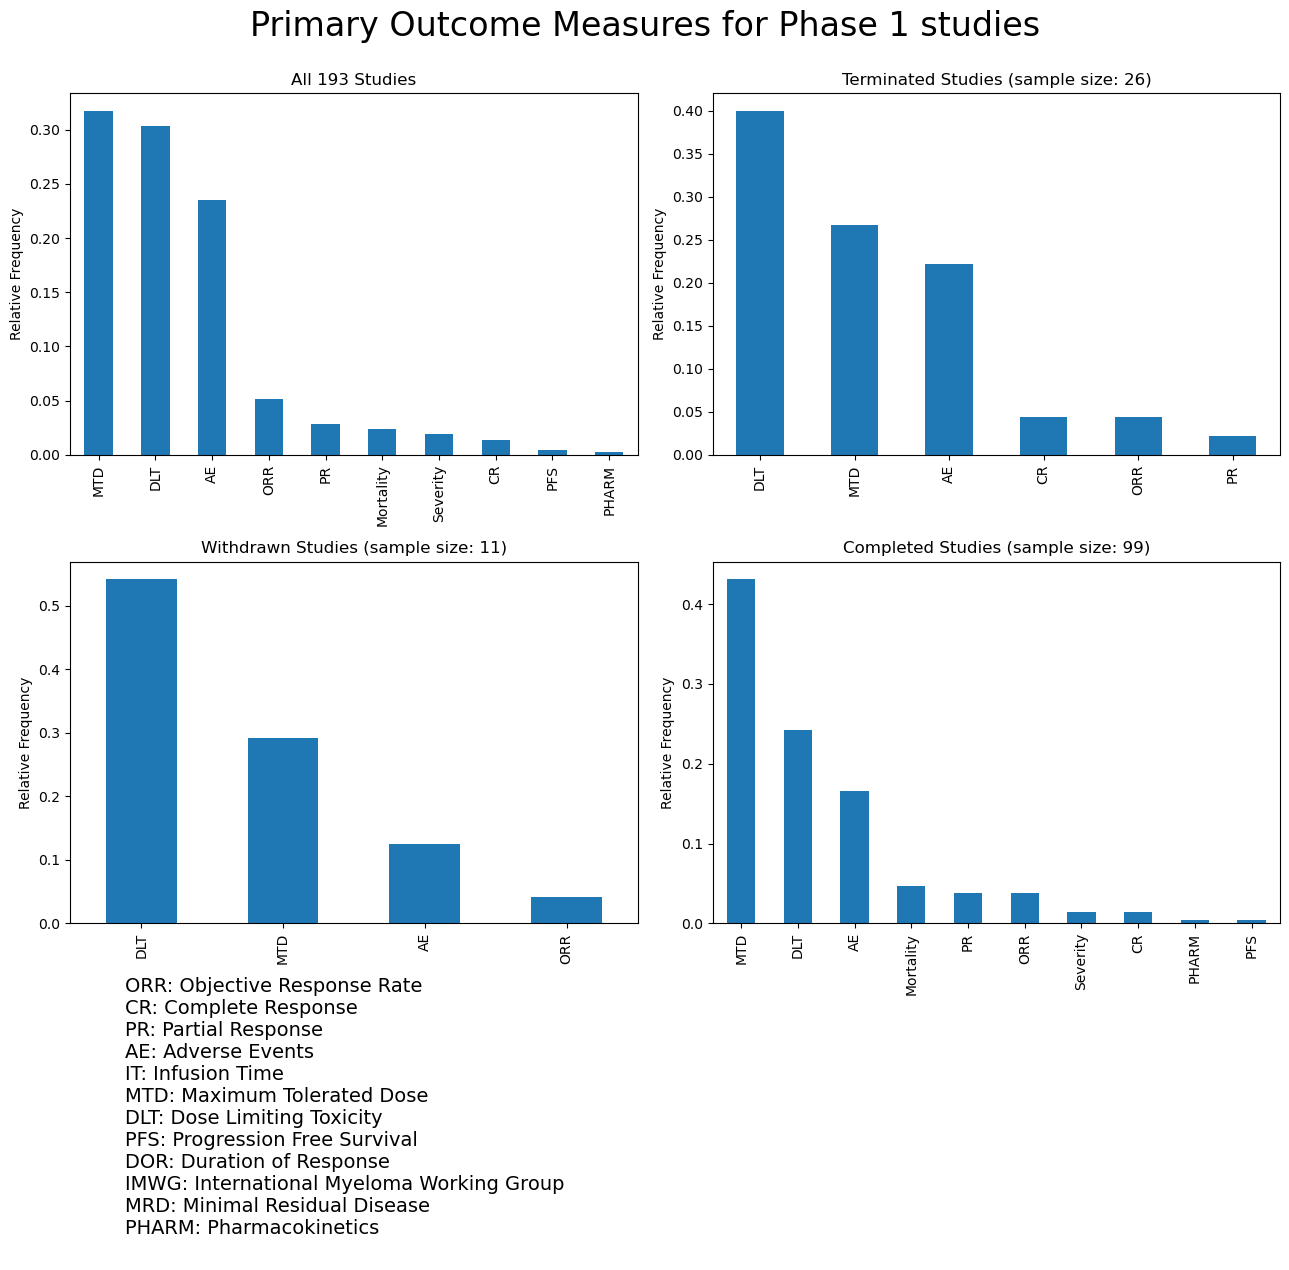

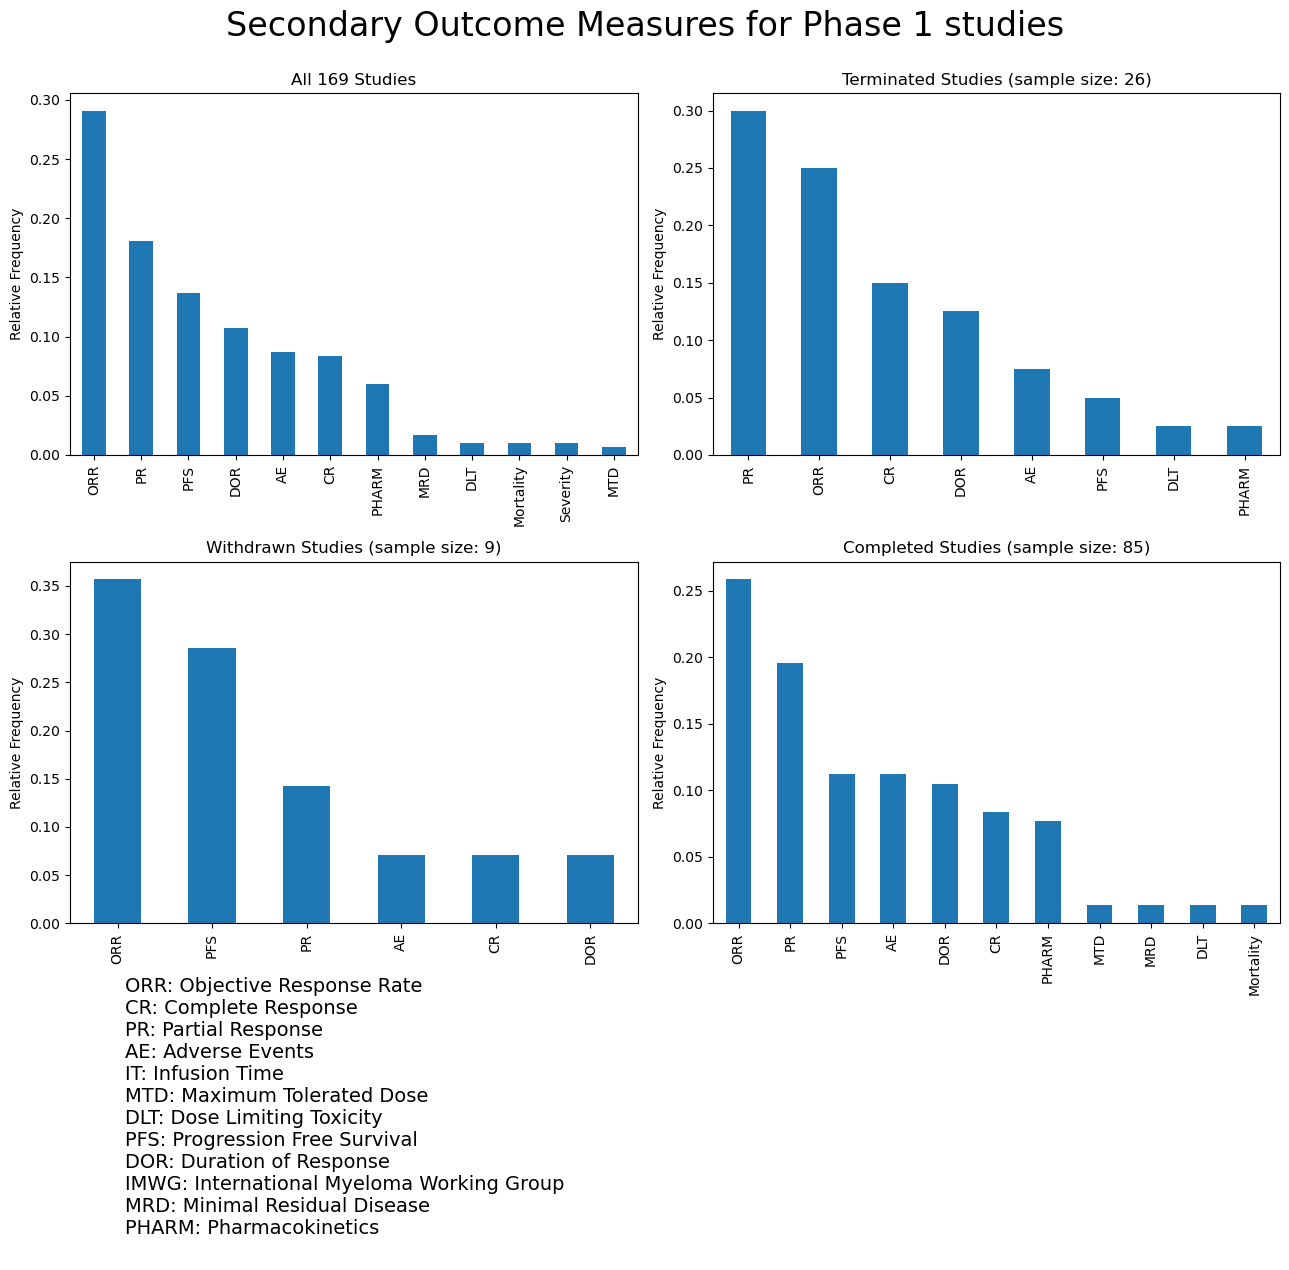

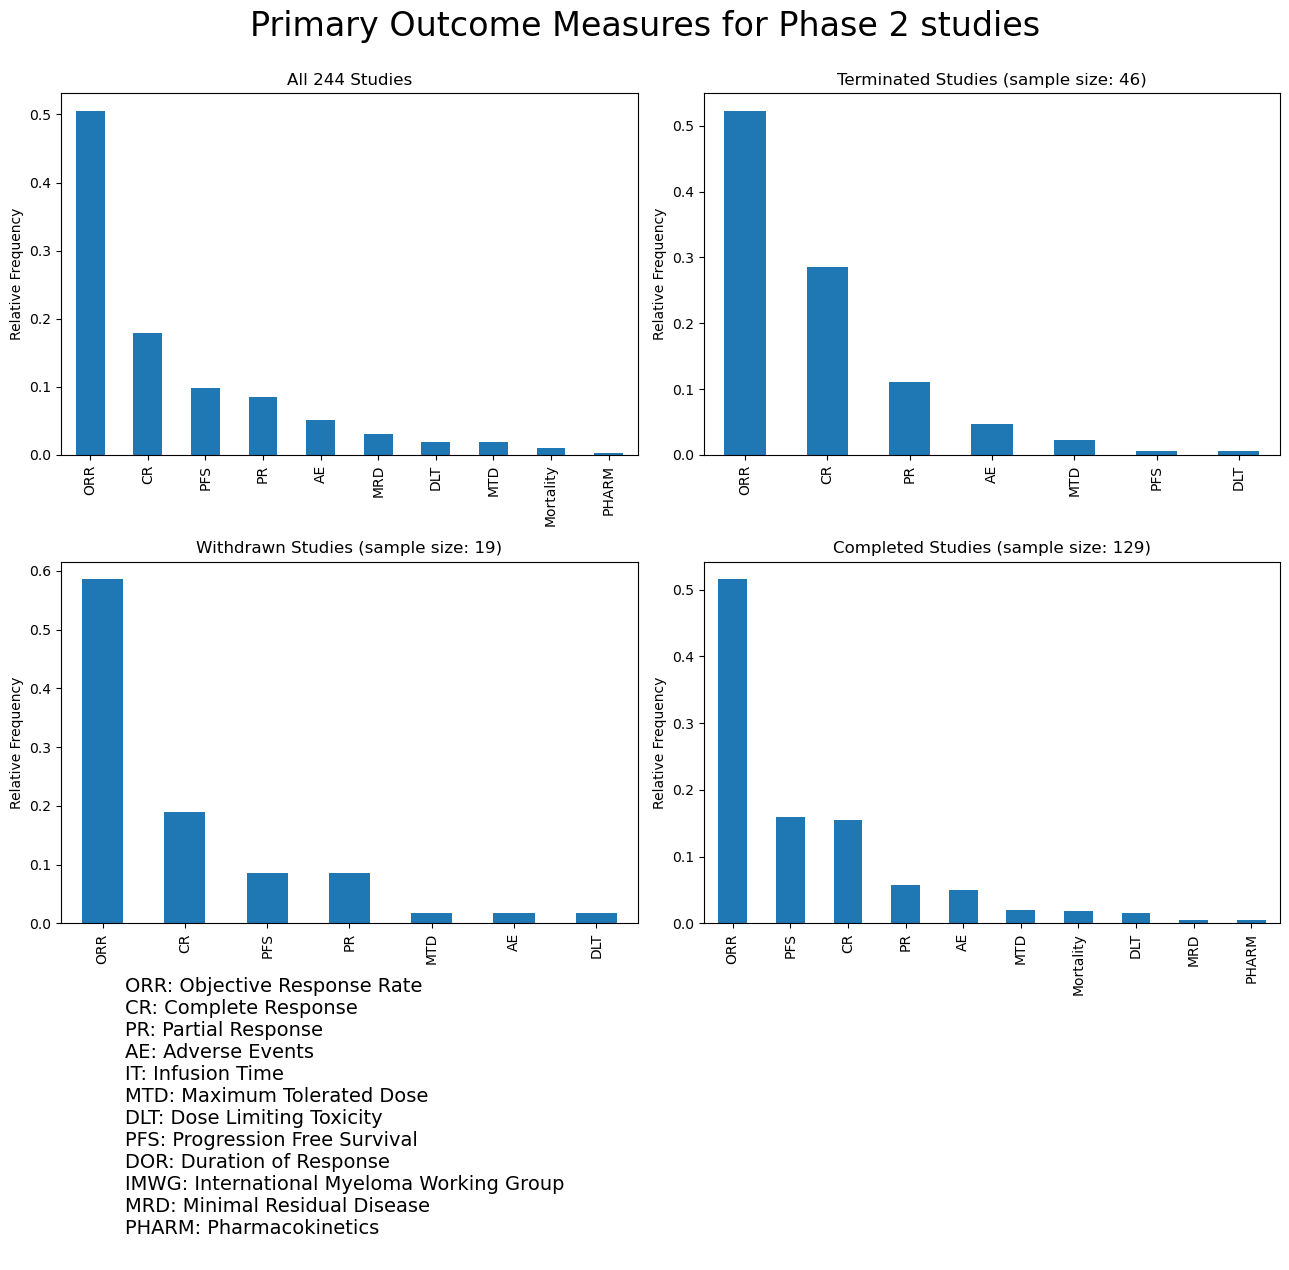

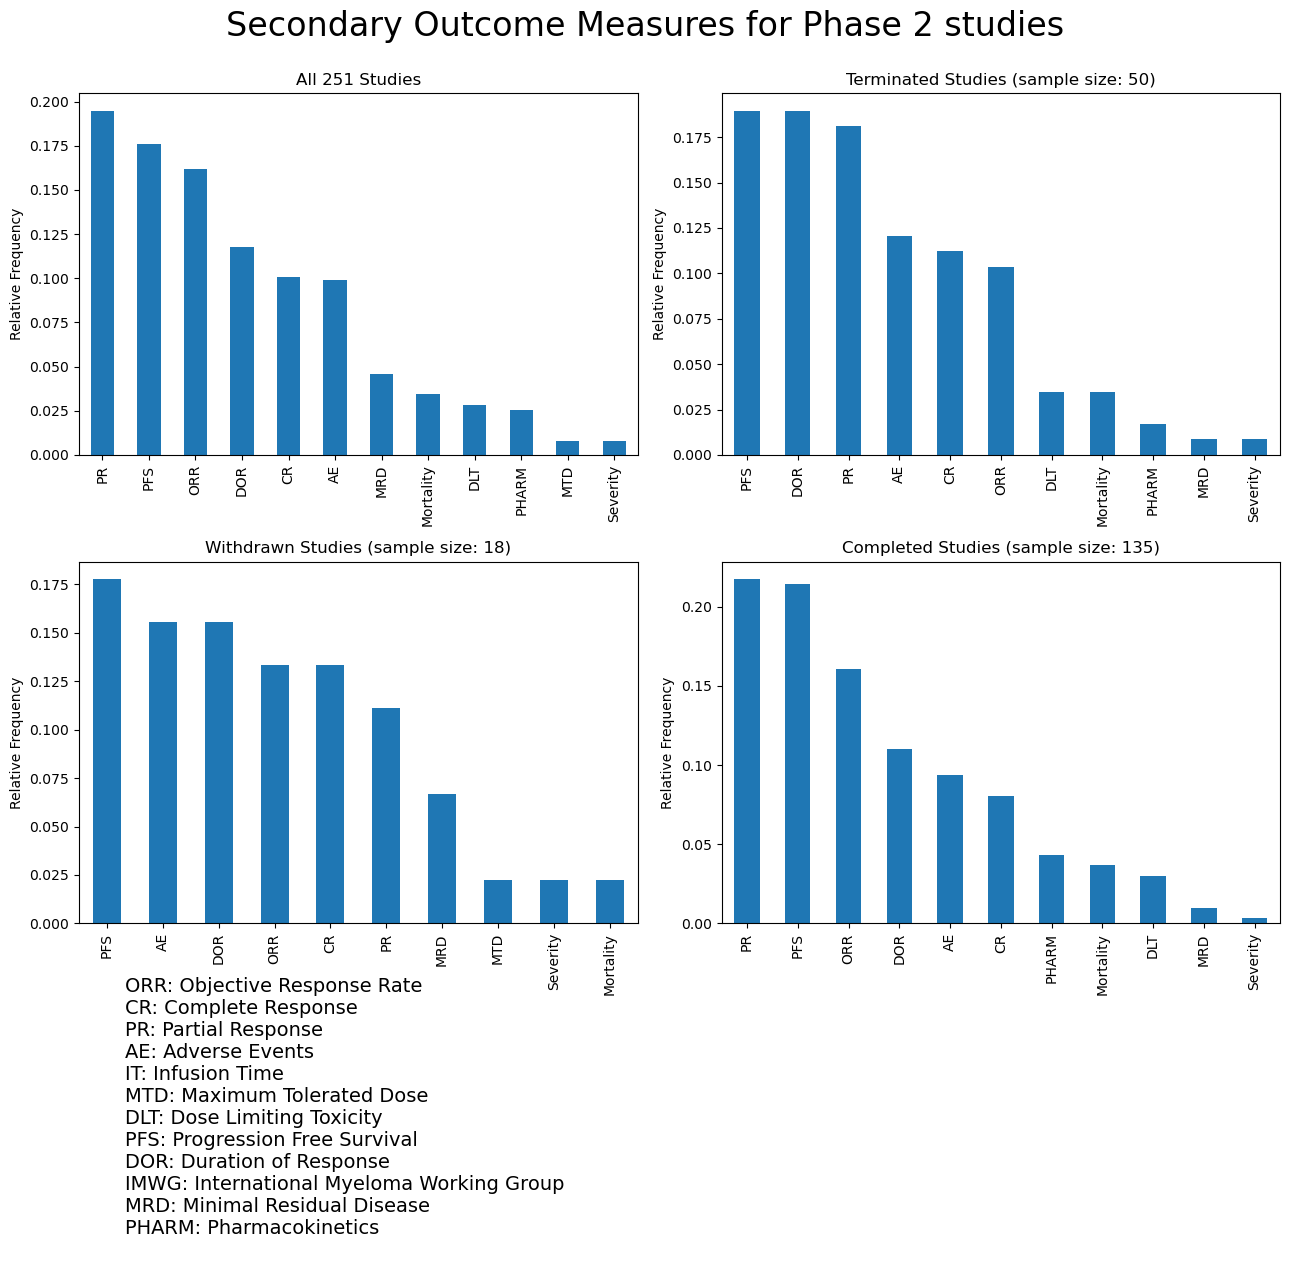

In [455]:
# THE DATA IS MUCH MORE SPARSE FOR LATER PHASES –– THROWS ERROR SO JUST DO IT MANUALLY
for phase in range(1, 3):
    make_plots(True, phase)
    make_plots(False, phase)

# DONT FOCUS ON THE STUFF BELOW THIS, THE ABOVE CELLS IMPROVE ON THEM

In [456]:
# count how many studies are in each phase (matters since phase 1 also has "early phase 1")
phase_counts = {}
for i in range(1, 5):
    phase_counts["Phase " + str(i)] = per_study[per_study["Phase"].str.contains(str(i))].shape[0]

<AxesSubplot:title={'center':'Relative Frequency of Primary Outcome Measures for 243 Phase 1 Trials'}, xlabel='Primary Outcome Measure', ylabel='Relative Frequency'>

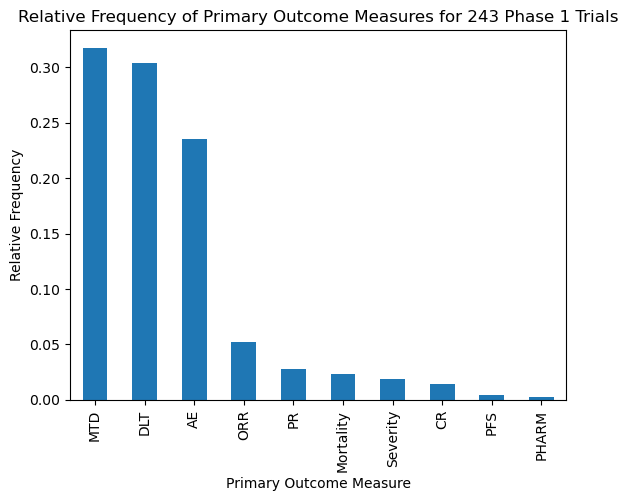

In [457]:
plt.figure()
classifiedcounts = df[(df['PrimaryCat'] != 'Unclassified') & (df['Phase'] == 'Phase 1')]['PrimaryCat'].value_counts()
classifiedcounts /= classifiedcounts.sum()
classifiedcounts.plot(kind='bar', title=f'Relative Frequency of Primary Outcome Measures for {phase_counts["Phase 1"]} Phase 1 Trials', xlabel='Primary Outcome Measure', ylabel='Relative Frequency')

<AxesSubplot:title={'center':'Relative Frequency of Primary Outcome Measures for 216 Phase 2 Trials'}, xlabel='Primary Outcome Measure', ylabel='Relative Frequency'>

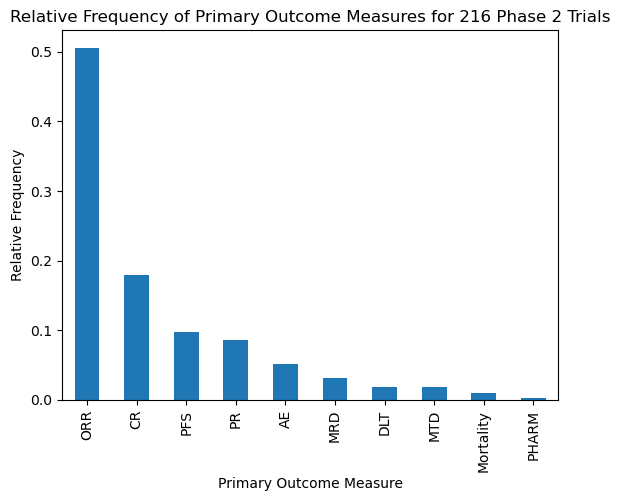

In [458]:
plt.figure()
classifiedcounts = df[(df['PrimaryCat'] != 'Unclassified') & (df['Phase'] == 'Phase 2')]['PrimaryCat'].value_counts()
classifiedcounts /= classifiedcounts.sum()
classifiedcounts.plot(kind='bar', title=f'Relative Frequency of Primary Outcome Measures for {phase_counts["Phase 2"]} Phase 2 Trials', xlabel='Primary Outcome Measure', ylabel='Relative Frequency')

<AxesSubplot:title={'center':'Relative Frequency of Primary Outcome Measures for 61 Phase 3 Trials'}, xlabel='Primary Outcome Measure', ylabel='Relative Frequency'>

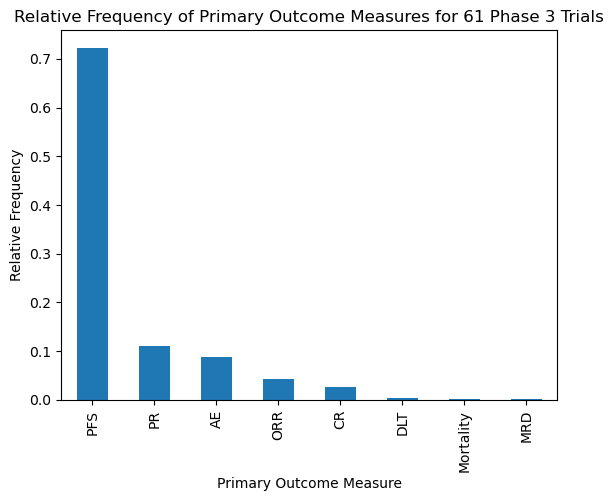

In [459]:
plt.figure()
classifiedcounts = df[(df['PrimaryCat'] != 'Unclassified') & (df['Phase'] == 'Phase 3')]['PrimaryCat'].value_counts()
classifiedcounts /= classifiedcounts.sum()
classifiedcounts.plot(kind='bar', title=f'Relative Frequency of Primary Outcome Measures for {phase_counts["Phase 3"]} Phase 3 Trials', xlabel='Primary Outcome Measure', ylabel='Relative Frequency')

In [460]:
# Apply the function to the dataframe
df['SecondCat'] = df['SecondaryOutcomeMeasure'].apply(classify_outcome_measure)

/var/folders/f1/87whmjt97m90gfstrm2p61d80000gn/T/ipykernel_10192/1520065185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SecondCat'] = df['SecondaryOutcomeMeasure'].apply(classify_outcome_measure)


<AxesSubplot:title={'center':'Relative Frequency of Secondary Outcome Measures for 243 Phase 1 Trials'}, xlabel='Secondary Outcome Measure', ylabel='Relative Frequency'>

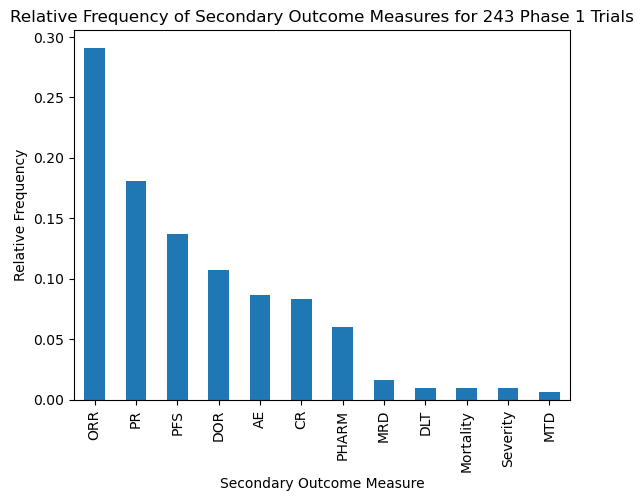

In [461]:
plt.figure()
classifiedcounts = df[(df['SecondCat'] != 'Unclassified') & (df['Phase'] == 'Phase 1')]['SecondCat'].value_counts()
classifiedcounts /= classifiedcounts.sum()
classifiedcounts.plot(kind='bar', title=f'Relative Frequency of Secondary Outcome Measures for {phase_counts["Phase 1"]} Phase 1 Trials', xlabel='Secondary Outcome Measure', ylabel='Relative Frequency')

<AxesSubplot:title={'center':'Relative Frequency of Secondary Outcome Measures for 216 Phase 2 Trials'}, xlabel='Secondary Outcome Measure', ylabel='Relative Frequency'>

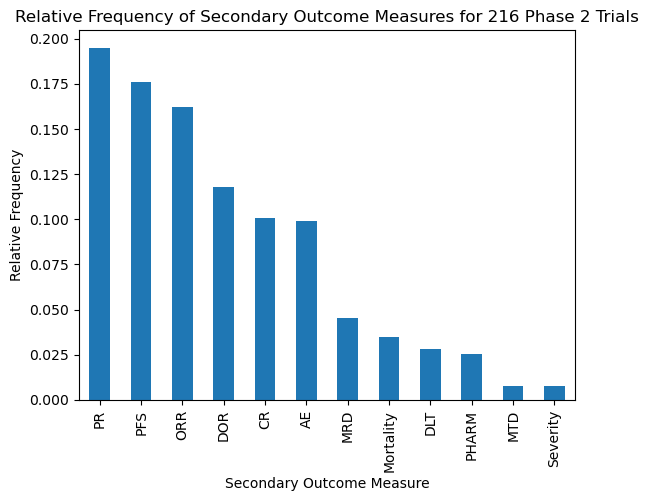

In [462]:
plt.figure()
classifiedcounts = df[(df['SecondCat'] != 'Unclassified') & (df['Phase'] == 'Phase 2')]['SecondCat'].value_counts()
classifiedcounts /= classifiedcounts.sum()
classifiedcounts.plot(kind='bar', title=f'Relative Frequency of Secondary Outcome Measures for {phase_counts["Phase 2"]} Phase 2 Trials', xlabel='Secondary Outcome Measure', ylabel='Relative Frequency')

<AxesSubplot:title={'center':'Relative Frequency of Secondary Outcome Measures for 61 Phase 3 Trials'}, xlabel='S Outcome Measure', ylabel='Relative Frequency'>

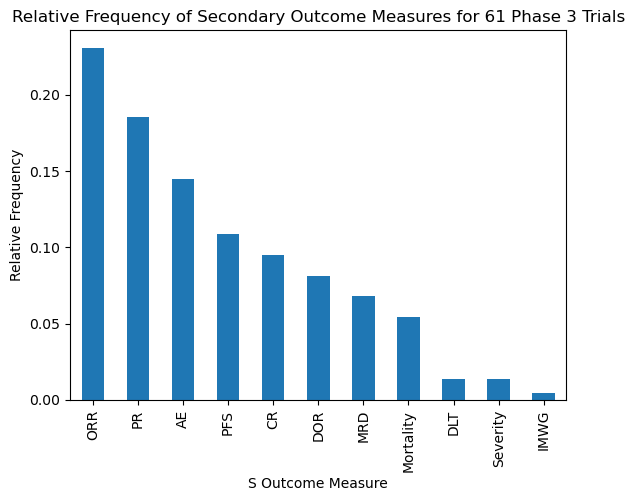

In [463]:
plt.figure()
classifiedcounts = df[(df['SecondCat'] != 'Unclassified') & (df['Phase'] == 'Phase 3')]['SecondCat'].value_counts()
classifiedcounts /= classifiedcounts.sum()
classifiedcounts.plot(kind='bar', title=f'Relative Frequency of Secondary Outcome Measures for {phase_counts["Phase 3"]} Phase 3 Trials', xlabel='S Outcome Measure', ylabel='Relative Frequency')